# Traduction statistique avec NLTK - Quelques concepts

## 1. Création du bitexte anglais-français

La traduction statistique utilise des textes parallèles en 2 langues pour apprendre comment traduire des textes. Un bitexte est un corpus dont le texte est disponible en 2 langues. On peut alors aligner les phrases de ces textes et, par la suite, trouver les mots qui correspondent de part et d'autre.

Pour cet exemple, nous avons récupéré sur le Web un corpus parallèle anglais-français de 100 000 phrases. On débute notre exemple en montant en mémoire ces phrases.

In [6]:
import json
    
with open("./data/train_en.json") as en_file:
    eng_sentences = json.load(en_file)
with open("./data/train_fr.json") as fr_file:
    fr_sentences = json.load(fr_file)

print("Nombre de phrases anglaises: ", len(eng_sentences))
print("Nombre de phrases françaises: ", len(fr_sentences))

print("Quelques phrases parallèles:")
for i in range(5):
    print("\n{}".format(eng_sentences[i]))
    print(fr_sentences[i])

Nombre de phrases anglaises:  100000
Nombre de phrases françaises:  100000
Quelques phrases parallèles:

['This', 'is', 'Bill', 'Lange.', "I'm", 'Dave', 'Gallo.']
['Voici', 'Bill', 'Lange.', 'Je', 'suis', 'Dave', 'Gallo.']

['And', "we're", 'going', 'to', 'tell', 'you', 'some', 'stories', 'from', 'the', 'sea', 'here', 'in', 'video.']
['Nous', 'allons', 'vous', 'raconter', 'quelques', 'histoires', 'de', 'la', 'mer', 'en', 'vidéo.']

["We've", 'got', 'some', 'of', 'the', 'most', 'incredible', 'video', 'of', 'Titanic', "that's", 'ever', 'been', 'seen,', 'and', "we're", 'not', 'going', 'to', 'show', 'you', 'any', 'of', 'it.']
['Nous', 'avons', 'des', 'vidéos', 'du', 'Titanic', 'parmi', 'les', 'plus', 'spectaculaires', 'jamais', 'vues.', 'et', 'nous', "n'allons", 'pas', 'vous', 'en', 'montrer', 'une', 'image.']

['The', 'truth', 'of', 'the', 'matter', 'is', 'that', 'the', 'Titanic', '--', 'even', 'though', "it's", 'breaking', 'all', 'sorts', 'of', 'box', 'office', 'records', '--', "it's", '

## 2. Alignement de phrases

L'alignement de phrases est simple pour cet exemple. Les 2 listes contiennent le même de phrases et les phrases à la position X des listes sont alignées ensemblent. La classe AlignedSent de NLTK permet de conserver les paires de phrases et les informations sur l'alignement de ces phrases.



In [7]:
from nltk.translate.api import AlignedSent

aligned_text = []  
for i in range(len(eng_sentences)):
    al_sent = AlignedSent(fr_sentences[i], eng_sentences[i])
    aligned_text.append(al_sent)

sentence_alignment =  aligned_text[0]
print("Phrase cible:",sentence_alignment.words)
print("Alignée avec phrase source:", sentence_alignment.mots)

Phrase cible: ['Voici', 'Bill', 'Lange.', 'Je', 'suis', 'Dave', 'Gallo.']
Alignée avec phrase source: ['This', 'is', 'Bill', 'Lange.', "I'm", 'Dave', 'Gallo.']


## 3. Entraînement de modèles de traduction IBM

NLTK offre des implémentations des modèles IBM (1 à 5). Nous allons nous limité ici au modèle IBM qui est présenté dans le matériel du cours. C'est le modèle le plus simple. Il permet toutefois de comprendre les principaux concepts reliés à l'alignement de mots individuels.

La première étape consiste à prendre toutes les paires de phrases alignées ensemble et à obtenir le modèle de traduction. Ce modèle donne la probabilité qu'un mot dans une langue source soit traduit par un autre mot dans une langue cible. Les paramètres du modèle sont appris à l'aide d'un algorithme d'apprentissage non supervisé de type "Expectation-Maximization" (voir matériel du cours pour plus de détail). Cet algorithme itératif met à jour à chaque étape les probabilités de traduction du modèle. On limite ici le nombre d'itération à 5. L'entraînement avec 100 000 pairs de phrases prend environ 8 minutes sur mon Macbook Pro (qui date de plusieurs années). Donc la patience est de mise lorsque vous roulerez cet exemple.

In [9]:
from nltk.translate.ibm1 import IBMModel1
import time

print("Entraînement du modèle IBM1...")
start_time = time.time()
nb_iterations = 5
ibm_model1 = IBMModel1(aligned_text, nb_iterations)
print("Training complete")
print("Entraînement complété en %s seconds ---".format(time.time() - start_time))

Entraînement du modèle IBM1...
Training complete
Entraînement complété en %s seconds ---


Un petit bout de code que vous pourrez réutiliser si vous voulez sauvegarder le modèle pour éviter le reconstruire à chaque fois que vous roulez ce notebook. À noter que le modèle prend environ 2000 MB de mémoire à stocker dans un fichier.

In [10]:
import dill as pickle
import gzip

fi = open('./ibm_model1.pkl','wb')
pickle.dump(ibm_model1,fi)
fi.close()

# pour monter en mémoire le modèle par la suite
with open('./ibm_model1.pkl', 'rb') as pickle_file:
    ibm_model1 = pickle.load(pickle_file)

## 4. Les paramètres du modèle de traduction IBM1

Lors de l'apprentissage du modèle IBM1, l'algorithme a estimé les probabilités que les mots dans la langue source soit traduits par des mots de la langue cible. Autrement dit, les probabilités de traduction de mots individuels. En voici quelques exemples pour notre modèle.

In [11]:
print("t(langue, language) = ", ibm_model1.translation_table['langue']['language'])
print("t(langue, Null) = ", ibm_model1.translation_table['langue'][None])


t(langue, language) =  0.38590347851494206
t(langue, Null) =  2.989972362038413e-11


In [12]:
import pandas as pd

def make_translation_dataframe(list_fr, list_en):
    verb_trans_probs = list()
    for word_en in list_en:
        parameters = dict()
        parameters['t(fr,en)'] =  word_en
        for word_fr in list_fr:
            parameters[word_fr] = round(ibm_model1.translation_table[word_fr][word_en], 6)
        verb_trans_probs.append(parameters)
    return pd.DataFrame(verb_trans_probs)
    
verbs_en = ["make", "makes", "do", "does", "take", "takes", "decide", "choose", "pick", "get"]
verbs_fr = ["faire", "fait", "prendre", "prend", "décider", "choisir", "obtenir"]

verbs_parameters = make_translation_dataframe(verbs_fr, verbs_en)
display(verbs_parameters)



,"t(fr,en)",faire,fait,prendre,prend,décider,choisir,obtenir
0,make,0.400846,0.004968,0.000542,0.000002,0.000000,0.000000,0.000001
1,makes,0.000883,0.384003,0.000000,0.000003,0.000010,0.000000,0.000010
2,do,0.501579,0.006606,0.000011,0.000000,0.000000,0.000000,0.000003
3,does,0.001681,0.214417,0.000000,0.000000,0.000010,0.000010,0.000000
4,take,0.017566,0.000897,0.430470,0.001284,0.000000,0.000000,0.000001
5,takes,0.000942,0.001038,0.000025,0.452807,0.000010,0.000000,0.000000
6,decide,0.001348,0.000000,0.000000,0.000010,0.521549,0.000338,0.000010
7,choose,0.001309,0.000124,0.002855,0.000000,0.000004,0.583688,0.000010
8,pick,0.000292,0.000339,0.130703,0.000010,0.000010,0.141101,0.000000
9,get,0.047224,0.001153,0.000100,0.000001,0.000000,0.000000,0.045078


In [13]:
nouns_fr = ["livre", "histoire", "image", "base", "pièce", "chambre", "salle"]
nouns_en = ["book", "cookbook", "story", "history", "image", "picture", "base", "basis", "database", "basic", "room"]

verbs_parameters = make_translation_dataframe(nouns_fr, nouns_en)
display(verbs_parameters)


,"t(fr,en)",livre,histoire,image,base,pièce,chambre,salle
0,book,0.875130,0.000000,0.000000,0.000000,0.000010,0.000010,0.000000
1,cookbook,0.321081,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010
2,story,0.000000,0.523640,0.000000,0.000010,0.000000,0.000010,0.000010
3,history,0.000010,0.151446,0.000000,0.000000,0.000000,0.000010,0.000010
4,image,0.000010,0.000000,0.671820,0.000010,0.000010,0.000010,0.000010
5,picture,0.000000,0.000010,0.308828,0.000010,0.000000,0.000010,0.000000
6,base,0.000010,0.000002,0.000010,0.759858,0.000000,0.000010,0.000010
7,basis,0.000010,0.000010,0.000010,0.549682,0.000010,0.000010,0.000010
8,database,0.000010,0.000010,0.000010,0.466398,0.000010,0.000010,0.000010
9,basic,0.000010,0.000000,0.000000,0.439953,0.000010,0.000010,0.000000


## 5. Les alignements entre mots de phrases
 
Les alignements de mots nous indiquent les mots d'une paires de phrases qui sont associés entre eux. Les alignements qui sont retournés indiquent les positions des mots dans les phrases. Nous présentons un exemple dans cette section.

Note: il faut que le modèle utilisé ait été entraîné sur les paires de phrases pour avoir les alignements de ces phrases. Autrement dit, si vous montez le modèle avec Pickle, les phrases du corpus ne seront pas alignées.

In [14]:
sentence_alignment =  aligned_text[10]
print("Phrase source:", sentence_alignment.mots)
print("Phrase cible:", sentence_alignment.words)
print("\nAlignement par position:", sentence_alignment.alignment)

print("\nLes mots correspondants à ces positions: ")
word_alignments = sorted(sentence_alignment.alignment, key = lambda x: x[0])
for idx, idy in word_alignments:
    x = sentence_alignment.words[idx]
    y = sentence_alignment.mots[idy]
    print("\t", x, "<--", y)


Phrase source: ['Most', 'of', 'the', 'animals', 'are', 'in', 'the', 'oceans.']
Phrase cible: ['La', 'plupart', 'des', 'animaux', 'se', 'trouvent', 'dans', 'les', 'océans.']

Alignement par position: 0-0 1-0 2-1 3-3 4-7 5-7 6-5 7-4 8-7

Les mots correspondants à ces positions: 
	 La <-- Most
	 plupart <-- Most
	 des <-- of
	 animaux <-- animals
	 se <-- oceans.
	 trouvent <-- oceans.
	 dans <-- in
	 les <-- are
	 océans. <-- oceans.


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

def display_alignment(alignment):
    source = sentence_alignment.words
    target = sentence_alignment.mots
    zeros = np.zeros((len(source), len(target)))  # nrows, ncolumns
    df = pd.DataFrame(np.zeros((len(target), len(source))), index=target, columns=source) 
    for idx, idy in sentence_alignment.alignment:
        df.iloc[idy, idx] = 1
    plt.figure(figsize = (12,8))
    ax = sns.heatmap(df, cbar=False, cmap="winter")
    ax.xaxis.tick_top()


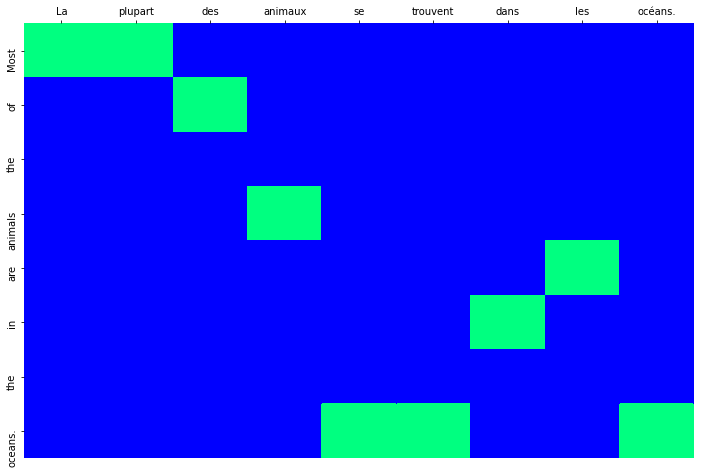

In [18]:
display_alignment(aligned_text[10])


## 6. Alignement de type phrased-based à partir des alignements de mots individuels


In [21]:
from nltk.translate.phrase_based import phrase_extraction

def extract_phrase_alignments(aligned_sentences):
    src_text = " ".join(aligned_sentences.mots)
    trg_text = " ".join(aligned_sentences.words)
    alignment = aligned_sentences.alignment
    phrase_alignments = phrase_extraction(src_text, trg_text, alignment)
    print("\nPhrase source:", src_text)
    print("Phrase cible:", trg_text)
    print("Alignement de mots individuels:", alignment, "\n")
    for phrase_alignment in sorted(phrase_alignments):
        print(phrase_alignment)
        
extract_phrase_alignments(aligned_text[7])



Phrase source: The average depth is about two miles.
Phrase cible: La profondeur moyenne est environ 3,2 km.
Alignement de mots individuels: 0-0 1-2 2-1 3-3 4-4 5-6 6-6 

((0, 1), (0, 1), 'The', 'La')
((0, 3), (0, 3), 'The average depth', 'La profondeur moyenne')
((0, 4), (0, 4), 'The average depth is', 'La profondeur moyenne est')
((0, 5), (0, 5), 'The average depth is about', 'La profondeur moyenne est environ')
((0, 5), (0, 6), 'The average depth is about', 'La profondeur moyenne est environ 3,2')
((0, 7), (0, 7), 'The average depth is about two miles.', 'La profondeur moyenne est environ 3,2 km.')
((1, 2), (2, 3), 'average', 'moyenne')
((1, 3), (1, 3), 'average depth', 'profondeur moyenne')
((1, 4), (1, 4), 'average depth is', 'profondeur moyenne est')
((1, 5), (1, 5), 'average depth is about', 'profondeur moyenne est environ')
((1, 5), (1, 6), 'average depth is about', 'profondeur moyenne est environ 3,2')
((1, 7), (1, 7), 'average depth is about two miles.', 'profondeur moyenne 

## 7. Évaluation de la traduction


In [20]:
from nltk.translate.bleu_score import sentence_bleu

cand1 = "Mary no slap the witch green".split()
cand2 = "Mary did not give a smack to a green witch".split()

ref1 = "Mary did not slap the green witch".split()
ref2 = "Mary did not smack the green witch".split()
ref3 = "Mary did not hit a green sorceress".split()
refs = [ref1, ref2, ref3]

print("\nLes deux traductions à évaluer:\n{}\n{}".format(cand1, cand2))
print("\nLes phrases de référence: ")
for ref in refs:
    print(ref)

ngram_weights=(0.5, 0.5, 0.0, 0.0)  # On utilise seulement les unigrammes et bigrammes pour l'évaluation
score1 = sentence_bleu(refs, cand1, weights=ngram_weights)
print("\nÉvaluation BLEU de cand1:", score1)

score2 = sentence_bleu(refs, cand2, weights=ngram_weights)
print("Évaluation BLEU de cand2:", score2)



Les deux traductions à évaluer:
['Mary', 'no', 'slap', 'the', 'witch', 'green']
['Mary', 'did', 'not', 'give', 'a', 'smack', 'to', 'a', 'green', 'witch']

Les phrases de référence: 
['Mary', 'did', 'not', 'slap', 'the', 'green', 'witch']
['Mary', 'did', 'not', 'smack', 'the', 'green', 'witch']
['Mary', 'did', 'not', 'hit', 'a', 'green', 'sorceress']

Évaluation BLEU de cand1: 0.3455747170954952
Évaluation BLEU de cand2: 0.557773351022717


c:\program files\python38\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\program files\python38\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
